# Training and Evaluating a POS Tagger

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import regex as re

import spacy
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from gensim.models.keyedvectors import load_word2vec_format
from gensim.models import Word2Vec, KeyedVectors

import torch
from torch import nn
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, confusion_matrix

from training import get_embedding_weights, POSDataset, Model, train_eval
from preprocessing import split_text_into_lines, extract_text_and_target, encode_text
from analysis import plot_learning_curve, inference_with_metrics, get_analysis_dataframe

## Preprocessing

### Create dataframe

In [4]:
with open('train.txt') as f:
    train_data = f.readlines()
with open('test.txt') as f:
    test_data = f.readlines()

In [5]:
# split text into lines

train_lines = split_text_into_lines(train_data)
test_lines = split_text_into_lines(test_data)

In [6]:
# put extract text and target from lines

train_text, train_targets = extract_text_and_target(train_lines)
test_text, test_targets = extract_text_and_target(test_lines)

In [7]:
train_df = pd.DataFrame(data={"text": train_text, "target": train_targets, "stage": ["train" for x in train_text]})
test_df = pd.DataFrame(data={"text": test_text, "target": test_targets, "stage": ["test" for x in test_text]})

In [8]:
df = pd.concat([train_df, test_df], axis=0)

In [9]:
df.head()

,text,target,stage
0,"[Confidence, in, the, pound, is, widely, expec...","[NN, IN, DT, NN, VBZ, RB, VBN, TO, VB, DT, JJ,...",train
1,"[Chancellor, of, the, Exchequer, Nigel, Lawson...","[NNP, IN, DT, NNP, NNP, NNP, POS, VBN, NN, TO,...",train
2,"[But, analysts, reckon, underlying, support, f...","[CC, NNS, VBP, VBG, NN, IN, NN, VBZ, VBN, VBN,...",train
3,"[This, has, increased, the, risk, of, the, gov...","[DT, VBZ, VBN, DT, NN, IN, DT, NN, VBG, VBN, T...",train
4,"[``, The, risks, for, sterling, of, a, bad, tr...","[``, DT, NNS, IN, NN, IN, DT, JJ, NN, NN, VBP,...",train


In [11]:
# check if length of text and target are the same for each sample

for idx, row in df.iterrows():
    if len(row["text"]) != len(row["target"]):
        print(idx)

### EDA

In [12]:
print(
    f"Total number of sentences:\n" 
    f"Training set {len(train_df)}\n"
    f"Test set {len(test_df)}"
)

Total number of sentences:
Training set 8937
Test set 2013


In [13]:
avg_train_sent_length = np.mean([len(row["text"]) for _, row in train_df.iterrows()])
avg_test_sent_length = np.mean([len(row["text"]) for _, row in test_df.iterrows()])
    
print(
    f"Avg. number of words per sentence:\n"
    f"Training set: {avg_train_sent_length:.1f}\n"
    f"Test set: {avg_test_sent_length:.1f}"
)

Avg. number of words per sentence:
Training set: 23.7
Test set: 23.5


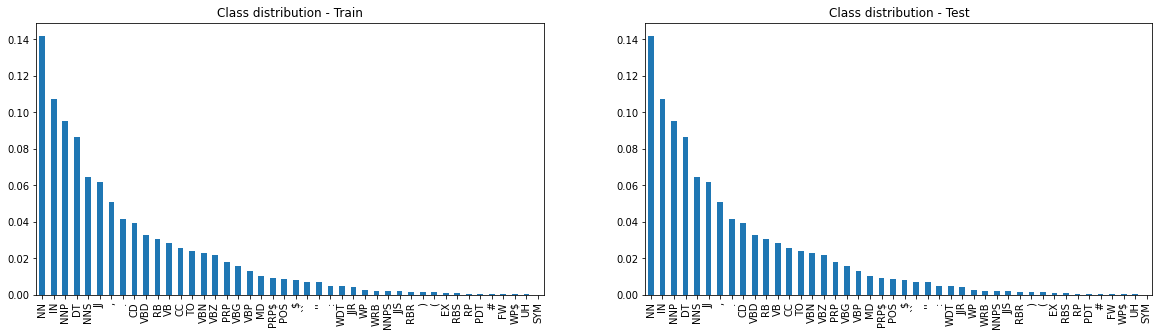

In [14]:
plt.figure(figsize=(20,5))

for plot, (string, data) in enumerate(zip(["Train", "Test"], [train_df, test_df])):
    
    pos_tags = list()
    for idx, row in df.iterrows():
        pos_tags.extend(row["target"])

    plt.subplot(1, 2, plot+1)
    pd.Series(pos_tags).value_counts(normalize=True).plot.bar()
    plt.title(f"Class distribution - {string}")
    
plt.show()

### Targets

In [15]:
# get all unique POS tags

unique_pos_tags = set()
for idx, row in df.iterrows():
    for tag in row["target"]:
        if tag not in unique_pos_tags:
            unique_pos_tags.add(tag)

print(unique_pos_tags)

{'FW', 'RB', 'TO', 'NNP', 'NNS', '#', 'VBG', 'WP', 'RBS', 'NN', 'UH', 'EX', 'IN', ')', 'VBN', 'NNPS', 'POS', '(', 'RBR', 'VB', 'PDT', 'VBZ', 'DT', '.', '``', 'PRP$', 'CD', 'JJR', '$', "''", ':', 'RP', 'VBP', 'WRB', 'CC', 'PRP', 'SYM', 'JJS', 'VBD', 'WDT', 'JJ', 'WP$', ',', 'MD'}


In [16]:
# create numerical encodings for POS tags

pos2value = dict()
pos2value[0] = 0
for idx, tag in enumerate(unique_pos_tags):
    pos2value[tag] = idx + 1  # because 0 will be padding token in both text and target

value2pos = {v: k for k, v in pos2value.items()}

print(pos2value)

{0: 0, 'FW': 1, 'RB': 2, 'TO': 3, 'NNP': 4, 'NNS': 5, '#': 6, 'VBG': 7, 'WP': 8, 'RBS': 9, 'NN': 10, 'UH': 11, 'EX': 12, 'IN': 13, ')': 14, 'VBN': 15, 'NNPS': 16, 'POS': 17, '(': 18, 'RBR': 19, 'VB': 20, 'PDT': 21, 'VBZ': 22, 'DT': 23, '.': 24, '``': 25, 'PRP$': 26, 'CD': 27, 'JJR': 28, '$': 29, "''": 30, ':': 31, 'RP': 32, 'VBP': 33, 'WRB': 34, 'CC': 35, 'PRP': 36, 'SYM': 37, 'JJS': 38, 'VBD': 39, 'WDT': 40, 'JJ': 41, 'WP$': 42, ',': 43, 'MD': 44}


In [76]:
for k in range(len(df["target"].iloc[0])):
    if df["target"].iloc[0][k] != value2pos[pos2value[df["target"].iloc[0][k]]]:
        print("wrong")

In [21]:
# encode targets in train and test set

targets_encoded = list()
for idx, row in df.iterrows():
    target_encoded = list()
    for tag in row["target"]:
        target_encoded.append(pos2value[tag])
    targets_encoded.append(target_encoded)

In [23]:
# get max sentence lengths 
sentence_lengths = [len(row["text"]) for idx, row in train_df.iterrows()]

max_seq_length = max(sentence_lengths)
print("Median sentence length", np.median(sentence_lengths))
print("Max sentence length", max_seq_length)

Median sentence length 23.0
Max sentence length 78


In [24]:
# pad targets to max sentence length

targets_padded = pad_sequences(targets_encoded, maxlen=max_seq_length, padding='post')
targets_padded = [target.tolist() for target in targets_padded]

In [25]:
print(f"Example target:\n"
      f"Length before padding: {len(targets_encoded[0])}\n"
      f"Length after padding: {len(targets_padded[0])}")

Example target:
Length before padding: 37
Length after padding: 78


In [26]:
df["target_encoded"] = targets_encoded
df["target_padded"] = targets_padded

### Inputs

#### Word IDs

In [27]:
# encode text

tokenizer = Tokenizer(filters="")
text_encoded, word2value = encode_text(df["text"], tokenizer)

In [28]:
# pad text

texts_padded = pad_sequences(text_encoded, maxlen=max_seq_length, padding='post')
texts_padded = [text.tolist() for text in texts_padded]

In [29]:
df["text_encoded"] = text_encoded
df["text_padded"] = texts_padded

In [30]:
print(f"Example text:\n"
      f"Length before padding: {len(text_encoded[0])}\n"
      f"Length after padding: {len(texts_padded[0])}")

Example text:
Length before padding: 37
Length after padding: 78


In [31]:
# check if padded text and padded targets have the same length

for idx in range(len(df)):
    if len(df["text_padded"].iloc[idx]) != len(df["target_padded"].iloc[idx]):
        print(idx)

In [32]:
df.sample(3)

,text,target,stage,target_encoded,target_padded,text_encoded,text_padded
1694,"[``, This, takes, any, question, of, Showtime,...","[``, DT, VBZ, DT, NN, IN, NNP, POS, NN, CC, VB...",test,"[25, 23, 22, 23, 10, 13, 4, 17, 10, 35, 22, 36...","[25, 23, 22, 23, 10, 13, 4, 17, 10, 35, 22, 36...","[13, 42, 1125, 112, 1146, 4, 2081, 10, 9498, 8...","[13, 42, 1125, 112, 1146, 4, 2081, 10, 9498, 8..."
686,"[People, often, cite, frugality, and, distrust...","[NNS, RB, VBP, NN, CC, NN, IN, NNS, TO, VB, NN...",test,"[5, 2, 33, 10, 35, 10, 13, 5, 3, 20, 10, 5, 3,...","[5, 2, 33, 10, 35, 10, 13, 5, 3, 20, 10, 5, 3,...","[115, 635, 7823, 18318, 8, 18319, 4, 266, 5, 5...","[115, 635, 7823, 18318, 8, 18319, 4, 266, 5, 5..."
314,"[Yesterday, 's, edition, provided, analysts, '...","[NN, POS, NN, VBD, NNS, POS, NNS, IN, DT, NN, ...",test,"[10, 17, 10, 39, 5, 17, 5, 13, 23, 10, 34, 41,...","[10, 17, 10, 39, 5, 17, 5, 13, 23, 10, 34, 41,...","[120, 10, 2446, 1029, 183, 132, 751, 9, 2, 41,...","[120, 10, 2446, 1029, 183, 132, 751, 9, 2, 41,..."


#### Word Embeddings

In [39]:
word2vec = load_word2vec_format("GoogleNews-vectors-negative300.bin", binary=True)

In [40]:
embedding_weights = get_embedding_weights(300, word2value, word2vec)

5713 words not in Word2Vec - initializing their weights with 0.


### Split dataset

In [93]:
# randomly split train data into training and validation set

train_df = df[df["stage"] == "train"].copy()
test_df = df[df["stage"] == "test"].copy()

train_df = train_df.sample(frac=1, random_state=0).reset_index(drop=True)
num_train_samples = int(len(train_df) * 0.9) + 1
num_valid_samples = int(len(train_df) * 0.1)

print(f"Number of training samples: {num_train_samples}\n"
      f"Number of validation samples: {num_valid_samples}")

Number of training samples: 8044
Number of validation samples: 893


In [94]:
valid_df = train_df[num_train_samples:].reset_index().copy()
train_df = train_df[:num_train_samples].reset_index()

(8044, 893)

### Data Loader

In [121]:
# dataset

train_ds = POSDataset(train_df["text_padded"], train_df["target_padded"]) 
valid_ds = POSDataset(valid_df["text_padded"], valid_df["target_padded"]) 
test_ds = POSDataset(test_df["text_padded"], test_df["target_padded"]) 

print("Dataset lengths:\n"
      f"Training: {len(train_df)}\n"
      f"Validation: {len(valid_ds)}\n"
      f"Test: {len(test_ds)}")

Dataset lengths:
Training: 8044
Validation: 893
Test: 2013


In [49]:
# data loader

train_dl = DataLoader(train_ds, batch_size=32)
valid_dl = DataLoader(valid_ds, batch_size=32, shuffle=False)

## Training

In [100]:
model = Model(
    output_size=len(pos2value),
    hidden_dim=64,
    n_layers=1,
    embedding_weights=embedding_weights,
    embedding_size=300
).double()

In [101]:
# start training

train_losses, valid_losses = train_eval(
    train_dataloader=train_dl, 
    valid_dataloader=valid_dl, 
    model=model,
    num_epochs=100,
    early_stopping=10,
    learning_rate=0.0001,
    weight_decay=1e-8,
    device=torch.device("cpu")
)

----- Epoch 1 ----- 
Avg. train loss 2.417
Avg. valid loss 2.726
----- Epoch 2 ----- 
Avg. train loss 0.995
Avg. valid loss 2.404
----- Epoch 3 ----- 
Avg. train loss 0.658
Avg. valid loss 2.107
----- Epoch 4 ----- 
Avg. train loss 0.391
Avg. valid loss 1.967
----- Epoch 5 ----- 
Avg. train loss 0.279
Avg. valid loss 1.740
----- Epoch 6 ----- 
Avg. train loss 0.211
Avg. valid loss 1.613
----- Epoch 7 ----- 
Avg. train loss 0.171
Avg. valid loss 1.419
----- Epoch 8 ----- 
Avg. train loss 0.143
Avg. valid loss 1.282
----- Epoch 9 ----- 
Avg. train loss 0.124
Avg. valid loss 1.121
----- Epoch 10 ----- 
Avg. train loss 0.109
Avg. valid loss 0.977
----- Epoch 11 ----- 
Avg. train loss 0.098
Avg. valid loss 0.834
----- Epoch 12 ----- 
Avg. train loss 0.089
Avg. valid loss 0.706
----- Epoch 13 ----- 
Avg. train loss 0.081
Avg. valid loss 0.589
----- Epoch 14 ----- 
Avg. train loss 0.075
Avg. valid loss 0.492
----- Epoch 15 ----- 
Avg. train loss 0.069
Avg. valid loss 0.411
----- Epoch 16 ----

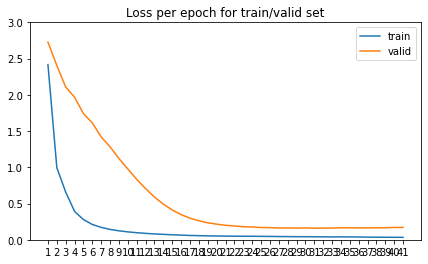

In [102]:
plot_learning_curve(train_losses, valid_losses)

## Evaluation

### Validating and Testing

In [103]:
valid_dl = DataLoader(valid_ds, batch_size=1, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=1, shuffle=False)

In [104]:
# get top-1 accuracy for validation set

correct_valid, total_valid = inference_with_metrics(model, valid_dl, classes=list(value2pos.keys()))

In [105]:
# get top-1 accuracy for test set

correct_test, total_test = inference_with_metrics(model, test_dl, classes=list(value2pos.keys()))

In [106]:
print(
    f"Valid Top-1 Accuracy: {correct_valid['all'] / total_valid['all']:.4f}\n"
    f"Test Top-1 Accuracy: {correct_test['all'] / total_test['all']:.4f}"
)

Valid Top-1 Accuracy: 0.8890
Test Top-1 Accuracy: 0.8667


### Analysis

In [135]:
metrics_df = get_analysis_dataframe(value2pos, correct_valid, correct_test, total_valid, total_test)

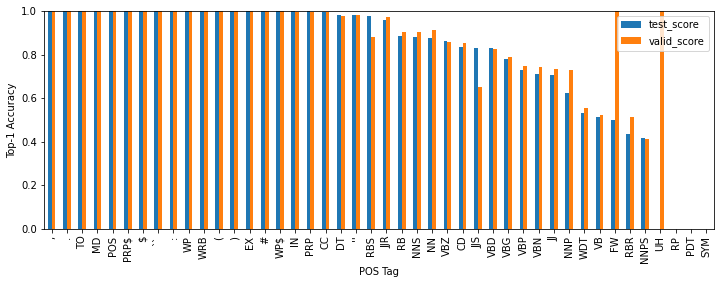

In [136]:
metrics_df.plot(
    x="tag", 
    y=["test_score", "valid_score"], 
    kind="bar", 
    ylim=(0,1), 
    figsize=(12, 4), 
    xlabel="POS Tag", 
    ylabel="Top-1 Accuracy"
);

In [137]:
metrics_df["test_samples_perc"] = metrics_df["test_samples"].div(metrics_df["test_samples"].sum(),axis=0)
metrics_df["valid_samples_perc"] = metrics_df["valid_samples"].div(metrics_df["valid_samples"].sum(),axis=0)

metrics_df_sorted = metrics_df.sort_values(["test_samples_perc"], ascending=False)

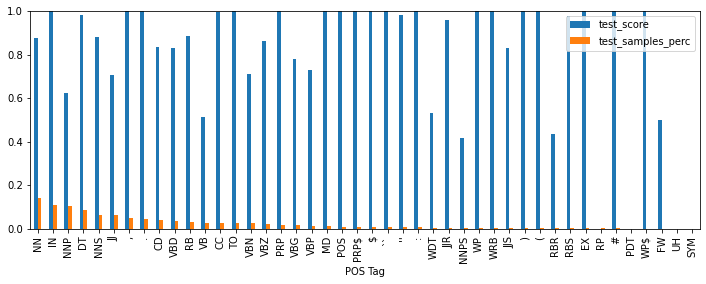

In [113]:
metric_df_sorted.plot(
    x="tag", 
    y=["test_score", "test_samples_perc"], 
    kind="bar", 
    ylim=(0,1), 
    figsize=(12, 4), 
    xlabel="POS Tag"
);

### Written-up Analysis

#### Differences and similarities between test and validation set

Overall, the results for the test and validation set are very similar, which means that their data distribution is likely to be very similar as well. The only classes that do not yield similar results on both sets are `FW` (with 0.5 and 1.0 on the test and validation set, respectively), `UH` ( with 0.0 and 0.1 on the test and validation set, respectively) and – to a lesser extent – `JJS` (with 0.83 and 0.65 on the test and validation set, respectively). What all three classes have in common is that there are quite few examples in both the test and validation set and it may well be that the examples that are easier to classify ended up in one dataset and the ones that are harder to classify ended up in the other.

#### Classes with few occurrences

On the one hand, out of 44 classes (excluding the padding class), 16 classes are classified perfectly (0.1 on both test and validation set) and 5 classes are classified almost perfectly (>0.98 on both test and validation set). On the other hand, for 4 (`UH`, `RP`, `PDT`, and `SYM`) and 3 (`RP`, `PDT`, and `SYM`) classes (on the test and validation set, respectively), not a single example was classified correctly. Those 4 classes have very little examples in each dataset (less than 12 for each class per dataset), the class `SYM` even has no examples at all, hence why none were classified correctly. Having few examples per class, however, is not predictive of low performance. In fact, there are some classes (`FW`, `WP$`, and `#` ) with very high top-1 accuracy that all have less than 11 occurrences per dataset.

Here, I would have a closer look at each example per class and analyze why for some infrequently-occurring classes the model performed well while for others it did not. My first best guess is that words belonging to the classes that the model performed badly on (such as `PDT` or `RP`) are very different to each other, while word belonging the classes that the model performed well on are very similar. In fact, the classes `#` and `WP$` virtually only include one word, namely `#` and `whose`, respectively, hence why the model might have learned them well despite only having seen a few examples.

#### Easy-to-learn classes

There are even more classes which only include a single word/symbol: all punctuation POS tags (i.e., `.`, `,`, `:`,`''`, `(`, `)`, and `$`) and the tag `TO`, which only includes the word `to`. All of them occurr frequently and were learned very well.

#### Worth-while improvements

Some classes have very high occurrences in both the test and validation set but the model did not perform as well on them as it did on other classes that occur with similar frequency. Out of the top-15 most frequent classes, `NN`, `JJ`, and `VB` performed worst, with 0.62, 0.71 and 0.51 top-1 accuracy on the test set, respectively. Focusing on improving the results for these three classes may be especially worth while, since a boost in their performance increases the model's overall performance as these classes occur so often. To do so, I would have a closer look at some examples and their prediction to see if the model makes any systematic mistakes or notice improvements for preprocessing. 

## Further Ideas

### Data Preprocessing

In terms of preprocessing, I noticed that around 5000 words are not in the Word2Vec vocabulary. These include a lot of numbers (most of them having the POS tag "CD") and hyphenated words.

My idea for handling numbers would be to replace them with a unique token such as "num" – however, the current models already learns the the class "CD" almost perfectly, so there probably is no need to deal with them. 

Regarding hyphenated words, I am still unsure how to handle them well. The biggest problem here is, that each word in the sentence corresponds to a POS tag. Splitting the hyphenated word into two words would result in a sentence that has one token more than its target, thus messing up how tags are assigned to tokens in the particular sample. One idea would be to still split hyphenated words and duplicate its POS tag. This way `("friendly-looking", "JJ")` would become `("friendly", "JJ"), ("looking", "JJ")`. 

### Model
The model I used is quite simple – one embedding, one RNN layer and one Conv layer – so there is a lot of room to experiment around with the architecture:
- the RNN layer could be replaced with a GRU or LSTM layer
- the number of RNN/GRU/LSTM layers could be increased
- the number of hidden dimensions could be increased

However, making the model more complex also holds the danger of overfitting (especially given the not-so-large dataset at hand), against which some measures could be taken:
- apply Dropout
- experiment with different values for weight decay

Of course, RNNs (as well as GRUs and LSTMs) come with their disadvantages. In general, they have problems with long-range dependencies and are slow to train. These problems are better handled by more recent NLP transformer models. One idea, thus, would be to finetune a pretrained BERT model. However, given the limited data we have, it might be a bit overkill to use BERT but maybe still worth a try.

### Analysis

There's also lots of room for further analysis of results. I had a look at the global and per-class top-1 accuracy, which gave me a general feeling of how well the model performs. Calculating and plotting a confusion matrix would provide an even better insight into the model's performance and would give information about which classes are frequently mixed up (although a confusion matrix with 45 classes might take a little bit of time to fully take in).

Comparing predictions and ground truth sample by sample might also provide some useful information why some of the classes were not learned that well. 

## Appendix

In [154]:
# metrics sorted by test_score
pd.options.display.float_format = "{:,.3f}".format
metrics_df

,description,tag,test_score,valid_score,test_samples,valid_samples,test_samples_perc,valid_samples_perc
0,",",",",1.000,1.000,2390,1023,0.050,0.049
1,.,.,1.000,1.000,1975,882,0.042,0.042
2,to,TO,1.000,1.000,1178,512,0.025,0.024
3,Modal,MD,1.000,1.000,470,183,0.010,0.009
4,Possessive ending,POS,1.000,1.000,434,176,0.009,0.008
5,Possessive pronoun,PRP$,1.000,1.000,421,197,0.009,0.009
6,$,$,1.000,1.000,384,169,0.008,0.008
7,``,``,1.000,1.000,323,151,0.007,0.007
8,:,:,1.000,1.000,238,103,0.005,0.005
9,Wh-pronoun,WP,1.000,1.000,110,49,0.002,0.002


In [153]:
# metrics sorted by test_samples
pd.options.display.float_format = "{:,.3f}".format
metrics_df_sorted

,description,tag,test_score,valid_score,test_samples,valid_samples,test_samples_perc,valid_samples_perc
25,"Noun, singular or mass",NN,0.877,0.912,6642,2980,0.140,0.143
16,Preposition or subordinating conjunction,IN,0.999,0.998,5071,2274,0.107,0.109
34,"Proper noun, singular",NNP,0.624,0.730,4806,1918,0.101,0.092
19,Determiner,DT,0.984,0.977,4020,1847,0.085,0.088
24,"Noun, plural",NNS,0.880,0.906,3034,1393,0.064,0.067
33,Adjective,JJ,0.707,0.735,2964,1296,0.063,0.062
0,",",",",1.000,1.000,2390,1023,0.050,0.049
1,.,.,1.000,1.000,1975,882,0.042,0.042
27,Cardinal number,CD,0.835,0.855,1918,862,0.040,0.041
29,"Verb, past tense",VBD,0.831,0.826,1679,684,0.035,0.033
